# Automated Environmental Analysis – MODIS and EMO Data Processing with Caching, Time Series Extraction, and Statistical Summaries #

This script provides a framework for retrieving, processing, and caching environmental datasets from MODIS and EMO sources. It supports time series extraction of key climate variables such as land surface temperature, NDVI, albedo, radiation, and precipitation over a specified region. To enhance performance, it implements chunked data retrieval to avoid timeouts and uses both persistent file-based and parameterized caching mechanisms. Output includes detailed visualizations, statistics and correletions matrix of temperature, vegetation, radiation, and other climate metrics.

**==============================================**
**Imports & Earth Engine Initialization**
**==============================================**

Imports all required libraries (data processing, visualization, Google Earth Engine, etc.) and initializes the Earth Engine API for use in the script.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import os
import xarray as xr
import pickle
import hashlib
import time
from IPython.display import display
import seaborn as sns
import ee

# Initialize Earth Engine
ee.Authenticate
ee.Initialize()

**==============================================**
**CONFIGURATION SECTION**
**==============================================**

Defines configuration settings and constants used throughout the analysis. The CACHE_PATHS dictionary specifies the file paths for storing cached data to avoid redundant processing. The SHARED_CONFIG dictionary contains structured configuration for both MODIS satellite data and EMO weather datasets. This includes the geographic point of interest (latitude and longitude), the temporal range of interest, scale resolution for spatial data, color settings for plotting variables, mappings from long variable names to short labels for clarity, and specific variable groupings that help in processing datasets consistently across functions.

In [2]:
# Define cache paths
CACHE_PATHS = {
    'primary': "/home/isense/Tripoli/all_data_cache.pkl",
    'secondary': "/home/isense/Tripoli/cached_data.pkl"
}

SHARED_CONFIG = {
    'modis': {
        'roi': ee.Geometry.Point([22.372, 37.652]),
        'start_date': '2000-01-01',
        'end_date': '2025-12-31',
        'scale': 1000,
        'colors': {
            'lst_day': 'magenta', 'lst_night': 'blue',
            'ndvi': 'green', 'albedo': 'black', 'et': 'cyan',
            'dsr': 'orange', 'direct': 'yellow', 'diffuse': 'purple'
        },
        'variable_config': {
            'lst_day_C': ['LST_Day_1km'],
            'lst_night_C': ['LST_Night_1km'],
            'lst_diff': ['LST_Diff_C'],
            'lst_day_8day_C': ['LST_Day_1km'],
            'lst_night_8day_C': ['LST_Night_1km'],
            'lst_diff_8day': ['LST_Diff_C'],
            'ndvi': ['NDVI'],
            'albedo': ['Albedo_BSA_shortwave'],
            'et': ['ET'],
            'emis_daily': ['Emis_31', 'Emis_32'],
            'emis_8day': ['Emis_31', 'Emis_32'],
            'radiation': ['DSR', 'Direct', 'Diffuse', 'GMT_0300_DSR','GMT_0600_DSR',
                         'GMT_0900_DSR', 'GMT_1200_DSR', 'GMT_1500_DSR']
        },
        'short_label_map': {
            'lst_day_C.LST_Day_1km': 'LST_day',
            'lst_night_C.LST_Night_1km': 'LST_night',
            'lst_diff.LST_Diff_C': 'LST_diff',
            'lst_day_8day_C.LST_Day_1km': 'LST_day_8d',
            'lst_night_8day_C.LST_Night_1km': 'LST_night_8d',
            'lst_diff_8day.LST_Diff_C': 'LST_diff_8d',
            'ndvi.NDVI': 'NDVI',
            'albedo.Albedo_BSA_shortwave': 'Albedo',
            'et.ET': 'ET',
            'emis_daily.Emis_31': 'Emis_31',
            'emis_daily.Emis_32': 'Emis_32',
            'emis_8day.Emis_31': 'Emis_31',
            'emis_8day.Emis_32': 'Emis_32',
            'radiation.DSR': 'Rad_DSR',
            'radiation.Direct': 'Rad_Direct',
            'radiation.Diffuse': 'Rad_Diffuse',
            'radiation.GMT_0300_DSR': 'Rad_0300',
            'radiation.GMT_0600_DSR': 'Rad_0600',
            'radiation.GMT_0900_DSR': 'Rad_0900',
            'radiation.GMT_1200_DSR': 'Rad_1200',
            'radiation.GMT_1500_DSR': 'Rad_1500',
        }
    },
    'emo': {
        'data_dir': "/home/isense/Tripoli/data",
        'roi_lon': 22.372,
        'roi_lat': 37.652,
        'variables': {
            'pr': 'Precipitation (mm)',
            'pd': 'Water Vapor Pressure (hPa)',
            'rg': 'Solar Radiation (J/m²)'
        },
        'colors': {
            'pr': '#1f77b4',
            'pd': '#9467bd',
            'rg': '#ff7f0e'
        }
    }
}

**==============================================**
**CACHING SYSTEM**
**==============================================**

Defines a DataCache class that handles the caching of processed datasets to disk. This helps avoid repeatedly querying and processing the same data. It supports saving data as .pkl files along with a timestamp and parameters, and it can load that data later if the same request is made.

In [3]:
class DataCache:
    """Enhanced caching system with version control"""
    
    def __init__(self, cache_dir="data_cache"):
        self.cache_dir = cache_dir
        os.makedirs(self.cache_dir, exist_ok=True)
        
    def _get_cache_key(self, data_source: str, params: dict) -> str:
        """Generate unique cache key for data source and parameters"""
        param_str = str(sorted(params.items())).encode('utf-8')
        return f"{data_source}_{hashlib.md5(param_str).hexdigest()}.pkl"
    
    def save(self, data, data_source: str, params: dict) -> str:
        """Save processed data to cache"""
        cache_file = os.path.join(self.cache_dir, self._get_cache_key(data_source, params))
        with open(cache_file, 'wb') as f:
            pickle.dump({
                'timestamp': datetime.now(),
                'data': data,
                'params': params
            }, f)
        return cache_file
    
    def load(self, data_source: str, params: dict):
        """Load processed data from cache if available"""
        cache_file = os.path.join(self.cache_dir, self._get_cache_key(data_source, params))
        if os.path.exists(cache_file):
            with open(cache_file, 'rb') as f:
                cache = pickle.load(f)
            if cache['params'] == params:
                return cache['data']
        return None

data_cache = DataCache()


**==============================================**
**DATA PROCESSING FUNCTIONS**
**==============================================**

The functions below extract and process geospatial and climate time series data from Google Earth Engine and NetCDF files (EMO data). It computes mean values over a defined region and structures the results into pandas DataFrames for analysis. To avoid timeouts with large datasets, it processes Earth Engine collections in yearly chunks. Climate variables from NetCDF are spatially matched to target coordinates, with built-in handling for unit conversions and missing values.  

In [4]:
def extract_time_series(image: ee.Image, roi: ee.Geometry, band_name: str) -> ee.Feature:
    """Extract time series for a single band from an Earth Engine image"""
    date = image.get('system:time_start')
    value = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=1000
    ).get(band_name)
    return ee.Feature(None, {'date': ee.Date(date).format('Y-M-d'), band_name: value})

def get_df_for_date_range(collection: ee.ImageCollection, roi: ee.Geometry, 
                         band_name: str, start_date: str, end_date: str, 
                         scale_factor: float = 1, offset: float = 0) -> pd.DataFrame:
    """Get DataFrame for a date range from an Earth Engine collection"""
    ts_collection = collection.filterDate(start_date, end_date)
    ts = ts_collection.map(lambda img: extract_time_series(img, roi, band_name)).filter(ee.Filter.notNull([band_name]))
    
    data = ts.getInfo()
    dates = []
    values = []
    
    for feature in data['features']:
        props = feature['properties']
        if band_name in props:
            dates.append(pd.Timestamp(props['date']))
            values.append(props[band_name] * scale_factor + offset if props[band_name] is not None else np.nan)
    
    return pd.DataFrame({'Date': dates, band_name: values}).dropna()

def get_modis_data_chunked(collection_id: str, band_name: str, 
                          scale_factor: float = 1, offset: float = 0) -> pd.DataFrame:
    """Get MODIS data in chunks to avoid timeout"""
    config = SHARED_CONFIG['modis']
    start_date_obj = pd.to_datetime(config['start_date'])
    end_date_obj = pd.to_datetime(config['end_date'])
    
    all_data = []
    current_start_date = start_date_obj
    
    while current_start_date < end_date_obj:
        next_end_date = current_start_date.replace(year=current_start_date.year + 1) - pd.Timedelta(days=1)
        if next_end_date > end_date_obj:
            next_end_date = end_date_obj
        
        print(f"Processing {band_name} data for {current_start_date.year}...")
        collection = ee.ImageCollection(collection_id)
        df = get_df_for_date_range(
            collection, config['roi'], band_name, 
            current_start_date.strftime('%Y-%m-%d'), 
            next_end_date.strftime('%Y-%m-%d'), 
            scale_factor, offset
        )
        all_data.append(df)
        current_start_date = next_end_date + pd.Timedelta(days=1)
    
    return pd.concat(all_data, ignore_index=True)

def extract_all_radiation(image: ee.Image, roi: ee.Geometry) -> ee.Feature:
    """Extract all radiation components from an Earth Engine image"""
    date = image.get('system:time_start')
    values = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=1000
    )
    
    properties = {
        'date': ee.Date(date).format('Y-M-d'),
        'DSR': values.get('DSR'),
        'Direct': values.get('Direct'),
        'Diffuse': values.get('Diffuse')
    }
    
    for hour in ['0000', '0300', '0600', '0900', '1200', '1500', '1800', '2100']:
        band_name = f'GMT_{hour}_DSR'
        properties[band_name] = values.get(band_name)
    
    return ee.Feature(None, properties)

def get_radiation_data_chunked() -> pd.DataFrame:
    """Special processing for radiation data in chunks"""
    config = SHARED_CONFIG['modis']
    start_date_obj = pd.to_datetime(config['start_date'])
    end_date_obj = pd.to_datetime(config['end_date'])
    
    all_data = []
    current_start_date = start_date_obj
    
    while current_start_date < end_date_obj:
        next_end_date = current_start_date.replace(year=current_start_date.year + 1) - pd.Timedelta(days=1)
        if next_end_date > end_date_obj:
            next_end_date = end_date_obj
        
        print(f"Processing radiation data for {current_start_date.year}...")
        collection = ee.ImageCollection("MODIS/062/MCD18A1")
        ts_collection = collection.filterDate(
            current_start_date.strftime('%Y-%m-%d'), 
            next_end_date.strftime('%Y-%m-%d')
        )
        ts = ts_collection.map(lambda img: extract_all_radiation(img, config['roi']))
        
        data = ts.getInfo()
        df_dict = {'Date': []}
        radiation_bands = ['DSR', 'Direct', 'Diffuse']
        
        for hour in ['0000', '0300', '0600', '0900', '1200', '1500', '1800', '2100']:
            radiation_bands.append(f'GMT_{hour}_DSR')
        
        for band in radiation_bands:
            df_dict[band] = []
        
        for feature in data['features']:
            props = feature['properties']
            if 'date' in props:
                df_dict['Date'].append(pd.Timestamp(props['date']))
                for band in radiation_bands:
                    df_dict[band].append(props[band] if props[band] is not None else np.nan)
        
        df = pd.DataFrame(df_dict).dropna()
        all_data.append(df)
        current_start_date = next_end_date + pd.Timedelta(days=1)
    
    return pd.concat(all_data, ignore_index=True)

def process_emo_variable(variable: str) -> pd.DataFrame:
    """Process EMO variable data from NetCDF files with precipitation handling"""
    config = SHARED_CONFIG['emo']
    folder_path = os.path.join(config['data_dir'], variable)
    file_paths = sorted([
        os.path.join(folder_path, f) 
        for f in os.listdir(folder_path) 
        if f.endswith('.nc')
    ])
    
    if not file_paths:
        print(f"No files found for variable {variable}")
        return None
    
    ds = xr.open_mfdataset(file_paths, combine='by_coords')
    
    abs_diff_lat = np.abs(ds['lat'] - config['roi_lat'])
    abs_diff_lon = np.abs(ds['lon'] - config['roi_lon'])
    closest_lat_idx = abs_diff_lat.argmin().item()
    closest_lon_idx = abs_diff_lon.argmin().item()
    
    values = ds[variable][:, closest_lat_idx, closest_lon_idx].values
    time = pd.to_datetime(ds['time'].values)
    
    df = pd.DataFrame({
        'Date': time,
        variable: values
    })
    
    # Handle specific variable transformations
    if variable in ['tx', 'tn']:
        if df[variable].max() > 200:  # Assume Kelvin if > 200
            df[variable] = df[variable] - 273.15
    
    # For precipitation, replace NaN with 0 (assuming NaN means no precipitation)
    if variable == 'pr':
        df[variable] = df[variable].fillna(0)
    
    return df

**==============================================**
**CACHED PROCESSING FUNCTIONS**
**==============================================**

This functions below handle loading and caching of MODIS and EMO datasets. This cell checks for existing cache files, processes data if needed, computes a correlation matrix, and updates the cache. This helps avoid redundant computation and speeds up data access.

In [5]:
def load_cached_data(file_path: str):
    """Load data from a specific cache file"""
    if os.path.exists(file_path):
        with open(file_path, 'rb') as f:
            return pickle.load(f)
    return None

def load_data_from_precached():
    """Try loading from cache files with priority"""
    for path in [CACHE_PATHS['primary'], CACHE_PATHS.get('secondary')]:
        if path and os.path.exists(path):
            data = load_cached_data(path)
            if data is not None:
                print(f"Loaded data from {path}")
                if 'correlation_matrix' not in data:
                    print("Adding missing correlation matrix to cache...")
                    data['correlation_matrix'] = create_correlation_matrix(data)
                    with open(path, "wb") as f:
                        pickle.dump(data, f)
                return data, True
    return None, False

def update_cache_files() -> dict:
    """Force an update of all cache files with current data"""
    print("Forcing cache update...")
    
    # Process all data from scratch
    modis_data = process_modis_data_with_cache()
    emo_data = process_emo_data_with_cache()
    
    # Create new complete dataset
    all_data = {
        'modis': modis_data,
        'emo': emo_data,
        'correlation_matrix': create_correlation_matrix({'modis': modis_data, 'emo': emo_data})
    }
    
    # Save to primary location
    with open(CACHE_PATHS['primary'], 'wb') as f:
        pickle.dump(all_data, f)
    
    print(f"Cache file updated at: {CACHE_PATHS['primary']}")
    return all_data

def get_modis_data_chunked_with_cache(collection_id: str, band_name: str, 
                                     scale_factor: float = 1, offset: float = 0) -> pd.DataFrame:
    """Get MODIS data with caching support"""
    cache_params = {
        'collection_id': collection_id,
        'band_name': band_name,
        'scale_factor': scale_factor,
        'offset': offset
    }
    
    cached_data = data_cache.load("modis", cache_params)
    if cached_data is not None:
        print(f"Loaded cached MODIS data for {collection_id}/{band_name}")
        return cached_data
    
    print(f"Processing MODIS data for {collection_id}/{band_name}...")
    data = get_modis_data_chunked(collection_id, band_name, scale_factor, offset)
    data_cache.save(data, "modis", cache_params)
    return data

def get_radiation_data_chunked_with_cache() -> pd.DataFrame:
    """Get radiation data with caching support"""
    cache_params = {'dataset': 'radiation'}
    
    cached_data = data_cache.load("modis_radiation", cache_params)
    if cached_data is not None:
        print("Loaded cached radiation data")
        return cached_data
    
    print("Processing radiation data...")
    data = get_radiation_data_chunked()
    data_cache.save(data, "modis_radiation", cache_params)
    return data

def process_emo_data_with_cache() -> dict:
    """Process EMO data with caching support"""
    cache_params = {'dataset': 'emo'}
    
    cached_data = data_cache.load("emo", cache_params)
    if cached_data is not None:
        print("Loaded cached EMO data")
        return cached_data
    
    print("Processing EMO data...")
    data_dict = {}
    
    for var in SHARED_CONFIG['emo']['variables'].keys():
        print(f"Processing {var}...")
        df = process_emo_variable(var)
        if df is not None:
            data_dict[var] = df
    
    data_cache.save(data_dict, "emo", cache_params)
    return data_dict

def process_modis_data_with_cache() -> dict:
    """Process all MODIS data with caching"""
    config = SHARED_CONFIG['modis']
    
    print("Processing MODIS data with chunking and caching...")
    datasets = {
        'lst_day': get_modis_data_chunked_with_cache("MODIS/061/MOD11A1", 'LST_Day_1km', 0.02),
        'lst_night': get_modis_data_chunked_with_cache("MODIS/061/MOD11A1", 'LST_Night_1km', 0.02),
        'lst_day_8day': get_modis_data_chunked_with_cache("MODIS/061/MOD11A2", 'LST_Day_1km', 0.02),
        'lst_night_8day': get_modis_data_chunked_with_cache("MODIS/061/MOD11A2", 'LST_Night_1km', 0.02),
        'ndvi': get_modis_data_chunked_with_cache("MODIS/061/MOD13A2", 'NDVI', 0.0001),
        'albedo': get_modis_data_chunked_with_cache("MODIS/061/MCD43A3", 'Albedo_BSA_shortwave', 0.001),
        'et': get_modis_data_chunked_with_cache("MODIS/061/MOD16A2", 'ET', 0.1),
        'radiation': get_radiation_data_chunked_with_cache()
    }

    # Get emissivity data - this is the key change
    print("Processing emissivity data...")
    emis_daily_31 = get_modis_data_chunked_with_cache("MODIS/061/MOD11A1", 'Emis_31', 0.002, 0.49)
    emis_daily_32 = get_modis_data_chunked_with_cache("MODIS/061/MOD11A1", 'Emis_32', 0.002, 0.49)
    emis_8day = get_modis_data_chunked_with_cache("MODIS/061/MOD11A2", 'Emis_31', 0.002, 0.49)
    emis_8day_32 = get_modis_data_chunked_with_cache("MODIS/061/MOD11A2", 'Emis_32', 0.002, 0.49)
    
    # Add to datasets
    datasets.update({
        'emis_daily_31': emis_daily_31,
        'emis_daily_32': emis_daily_32,
        'emis_8day_31': emis_8day,
        'emis_8day_32': emis_8day_32
    })

    # Convert LST to Celsius
    for lst_key in ['lst_day', 'lst_night', 'lst_day_8day', 'lst_night_8day']:
        datasets[lst_key + '_C'] = datasets[lst_key].copy()
        col_name = datasets[lst_key].columns[1]
        datasets[lst_key + '_C'][col_name] = datasets[lst_key][col_name] - 273.15

    # Calculate LST differences
    datasets['lst_diff'] = pd.merge(datasets['lst_day_C'], datasets['lst_night_C'], on='Date', how='outer')
    datasets['lst_diff']['LST_Diff_C'] = datasets['lst_diff']['LST_Day_1km'] - datasets['lst_diff']['LST_Night_1km']

    datasets['lst_diff_8day'] = pd.merge(datasets['lst_day_8day_C'], datasets['lst_night_8day_C'], on='Date', how='outer')
    datasets['lst_diff_8day']['LST_Diff_C'] = datasets['lst_diff_8day']['LST_Day_1km'] - datasets['lst_diff_8day']['LST_Night_1km']
    
    return datasets

def load_or_process_data(force_reprocess: bool = False) -> tuple:
    """Load data from cache or process from scratch"""
    print("\n=== Starting load_or_process_data ===")
    
    if not force_reprocess:
        # Try loading from precached files first
        precached_data, loaded = load_data_from_precached()
        if loaded:
            return precached_data, True
        
        # Fall back to normal cache
        complete_cache = data_cache.load("complete_dataset", {})
        if complete_cache is not None:
            print("Successfully loaded from normal cache")
            if 'correlation_matrix' not in complete_cache:
                print("Adding missing correlation matrix to normal cache...")
                complete_cache['correlation_matrix'] = create_correlation_matrix(complete_cache)
                data_cache.save(complete_cache, "complete_dataset", {})
            return complete_cache, True
    
    # Process data from scratch if cache not available or force_reprocess=True
    print("Processing data from scratch...")
    modis_data = process_modis_data_with_cache()
    emo_data = process_emo_data_with_cache()
    
    all_data = {
        'modis': modis_data,
        'emo': emo_data,
        'correlation_matrix': create_correlation_matrix({'modis': modis_data, 'emo': emo_data})
    }
    
    # Save to cache systems
    print("Saving to cache systems...")
    data_cache.save(all_data, "complete_dataset", {})
    
    with open(CACHE_PATHS['primary'], "wb") as f:
        pickle.dump(all_data, f)
    print(f"Saved to {CACHE_PATHS['primary']}")
    
    return all_data, False

**==============================================**
**ANALYSIS FUNCTIONS**
**==============================================**

The following cell generates summary statistics, a correlation matrix, and seasonal data analysis for both MODIS and EMO datasets. It calculates key statistics (mean, min, max, and standard deviation) for each variable, creates a clean correlation matrix with simplified names, and generates seasonal statistics (winter, spring, summer, fall) for the datasets.

In [6]:
def generate_summary_statistics(all_data: dict) -> dict:
    """Generate summary statistics for all variables"""
    # MODIS summary
    modis_summary = summarize_modis_variables(all_data['modis'])
    
    # EMO summary
    emo_stats = []
    for var, df in all_data['emo'].items():
        if isinstance(df, pd.DataFrame):
            series = df[var].dropna()
            emo_stats.append({
                'Variable': var,
                'Mean': series.mean(),
                'Min': series.min(),
                'Max': series.max(),
                'StdDev': series.std()
            })
    emo_summary = pd.DataFrame(emo_stats)
    
    return {
        'modis_summary': modis_summary,
        'emo_summary': emo_summary
    }

def summarize_modis_variables(datasets: dict) -> pd.DataFrame:
    """Summarize MODIS variables using shared config"""
    config = SHARED_CONFIG['modis']
    summary_rows = []

    for dataset_name, column_list in config['variable_config'].items():
        if dataset_name in datasets:
            df = datasets[dataset_name]
            for col in column_list:
                if col in df.columns:
                    series = df[col].dropna()
                    if not series.empty:
                        full_name = f'{dataset_name}.{col}'
                        short_label = config['short_label_map'].get(full_name, full_name)
                        summary_rows.append({
                            'Variable': short_label,
                            'Mean': series.mean(),
                            'Min': series.min(),
                            'Max': series.max(),
                            'StdDev': series.std()
                        })

    return pd.DataFrame(summary_rows)

def create_correlation_matrix(all_data: dict) -> pd.DataFrame:
    """Create clean correlation matrix with simplified column names"""
    combined_df = pd.DataFrame()
    
    # Add MODIS data
    for key, df in all_data['modis'].items():
        if isinstance(df, pd.DataFrame):
            # Skip radiation data as we'll add it separately
            if key == 'radiation':
                continue
                
            # Skip all 8-day data and original Kelvin temperature data
            if key in ['lst_day_8day', 'lst_night_8day', 'lst_day_8day_C', 
                      'lst_night_8day_C', 'lst_diff_8day', 'emis_8day_31.Emis_31','emis_8day_32.Emis_32',
                      'lst_day', 'lst_night']:
                continue
                
            # Get the value column (first non-Date column)
            value_col = [col for col in df.columns if col != 'Date'][0]
            
            # Use simplified names for LST variables
            # Skip radiation data as we'll add it separately
            # if key == 'radiation':
            #     continue

            # Skip all 8-day data and original Kelvin temperature data
            if key.startswith('lst_') and '8day' in key:
                continue
            if key.startswith('emis_8day'):
                continue
            if key in ['lst_day', 'lst_night']:
                continue

            # Get the value column (first non-Date column)
            value_col = [col for col in df.columns if col != 'Date'][0]

            # Simplify column names
            if key == 'lst_day_C':
                short_name = 'LST_Day'
            elif key == 'lst_night_C':
                short_name = 'LST_Night'
            elif key == 'lst_diff':
                short_name = 'LST_Diff'
            elif key == 'emis_daily_31' and value_col == 'Emis_31':
                short_name = 'Emis31_D'
            elif key == 'emis_daily_32' and value_col == 'Emis_32':
                short_name = 'Emis32_D'
            else:
                full_name = f"{key}.{value_col}"
                short_name = SHARED_CONFIG['modis']['short_label_map'].get(full_name, full_name)

            
            # Add to combined DataFrame
            temp_df = df[['Date', value_col]].copy()
            temp_df = temp_df.rename(columns={value_col: short_name})
            combined_df = pd.merge(combined_df, temp_df, on='Date', how='outer') if not combined_df.empty else temp_df
    
    # Add radiation data (excluding specified columns)
    if 'radiation' in all_data['modis']:
        radiation_df = all_data['modis']['radiation'].copy()
        # Exclude specified columns
        exclude_cols = ['GMT_1800_DSR', 'GMT_0000_DSR', 'GMT_2100_DSR']
        radiation_df = radiation_df.drop(columns=[col for col in exclude_cols if col in radiation_df.columns])
        
        # Rename columns using short labels
        for col in radiation_df.columns:
            if col != 'Date':
                if col.startswith('GMT_'):
                    # Convert GMT_0300_DSR to Rad_0300 format
                    hour = col.split('_')[1]
                    short_name = f'Rad_{hour}'
                else:
                    full_name = f"radiation.{col}"
                    short_name = SHARED_CONFIG['modis']['short_label_map'].get(full_name, full_name)
                radiation_df = radiation_df.rename(columns={col: short_name})
        
        combined_df = pd.merge(combined_df, radiation_df, on='Date', how='outer')
    
    # Add EMO data (excluding precipitation)
    for var, df in all_data['emo'].items():
        if isinstance(df, pd.DataFrame) and var != 'pr':  # Skip precipitation
            short_name = SHARED_CONFIG['emo']['variables'].get(var, var)
            temp_df = df[['Date', var]].copy()
            temp_df = temp_df.rename(columns={var: short_name})
            combined_df = pd.merge(combined_df, temp_df, on='Date', how='outer')
    
    # Filter to overlapping date range (2000-2023)
    combined_df = combined_df[
        (combined_df['Date'] >= '2000-01-01') & 
        (combined_df['Date'] <= '2023-12-31')
    ]
    
    # Calculate correlation matrix
    corr_matrix = combined_df.drop(columns=['Date']).corr()
    
    # Reorder columns to put LST variables first
    preferred_order = ['LST_Day', 'LST_Night', 'LST_Diff'] + \
                     [col for col in corr_matrix.columns 
                      if col not in ['LST_Day', 'LST_Night', 'LST_Diff']]
    
    return corr_matrix.loc[preferred_order, preferred_order]

def analyze_seasonal_data(all_data: dict) -> dict:
    """Generate seasonal statistics for both MODIS and EMO data"""
    seasonal_results = {}
    
    # Process MODIS data
    modis_seasonal = {}
    for key, df in all_data['modis'].items():
        if isinstance(df, pd.DataFrame) and 'Date' in df.columns:
            df_copy = df.copy()
            df_copy['Date'] = pd.to_datetime(df_copy['Date'])
            df_copy['Season'] = (df_copy['Date'].dt.month % 12) // 3 + 1
            season_mapping = {1: "Winter", 2: "Spring", 3: "Summer", 4: "Fall"}
            df_copy['Season'] = df_copy['Season'].map(season_mapping)
            
            value_col = [col for col in df_copy.columns if col not in ['Date', 'Season']][0]
            stats = df_copy.groupby('Season')[value_col].agg(['mean', 'std', 'min', 'max'])
            modis_seasonal[key] = stats
    
    # Process EMO data
    emo_seasonal = {}
    for key, df in all_data['emo'].items():
        if isinstance(df, pd.DataFrame) and 'Date' in df.columns:
            df_copy = df.copy()
            df_copy['Date'] = pd.to_datetime(df_copy['Date'])
            df_copy['Season'] = (df_copy['Date'].dt.month % 12) // 3 + 1
            df_copy['Season'] = df_copy['Season'].map({1: "Winter", 2: "Spring", 3: "Summer", 4: "Fall"})
            
            value_col = [col for col in df_copy.columns if col not in ['Date', 'Season']][0]
            stats = df_copy.groupby('Season')[value_col].agg(['mean', 'std', 'min', 'max'])
            emo_seasonal[key] = stats
    
    return {
        'modis_seasonal': modis_seasonal,
        'emo_seasonal': emo_seasonal
    }

**==============================================**
**DISPLAY FUNCTIONS**
**==============================================**

The following functions display summary statistics, seasonal statistics, and a correlation matrix. It prints and styles the dataframes for both MODIS and EMO datasets, showing detailed summary stats (mean, min, max, and standard deviation) and seasonal trends (winter, spring, summer, fall). The correlation matrix is also displayed, providing insights into the relationships between variables across the datasets.

In [7]:
def display_summary_stats(stats: dict):
    """Display summary statistics as formatted DataFrames"""
    print("\n=== MODIS Summary Statistics ===")
    modis_df = stats['modis_summary'].copy()
    numeric_cols = modis_df.select_dtypes(include=['float64', 'int64']).columns
    styled_modis = modis_df.style
    if not numeric_cols.empty:
        styled_modis = styled_modis.format("{:.4f}", subset=numeric_cols)
    display(styled_modis)
    
    print("\n=== EMO Summary Statistics ===")
    emo_df = stats['emo_summary'].copy()
    numeric_cols = emo_df.select_dtypes(include=['float64', 'int64']).columns
    styled_emo = emo_df.style
    if not numeric_cols.empty:
        styled_emo = styled_emo.format("{:.4f}", subset=numeric_cols)
    display(styled_emo)

def display_seasonal_stats(seasonal_stats: dict):
    """Display seasonal statistics as formatted DataFrames"""
    print("\n=== MODIS Seasonal Statistics ===")
    for var, stats_df in seasonal_stats['modis_seasonal'].items():
        short_name = SHARED_CONFIG['modis']['short_label_map'].get(f"{var}.{stats_df.columns[0]}", var)
        print(f"\n{short_name}:")
        df = stats_df.copy()
        numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
        styled_df = df.style
        if not numeric_cols.empty:
            styled_df = styled_df.format("{:.4f}", subset=numeric_cols)
        display(styled_df)
    
    print("\n=== EMO Seasonal Statistics ===")
    for var, stats_df in seasonal_stats['emo_seasonal'].items():
        var_name = SHARED_CONFIG['emo']['variables'].get(var, var)
        print(f"\n{var_name}:")
        df = stats_df.copy()
        numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
        styled_df = df.style
        if not numeric_cols.empty:
            styled_df = styled_df.format("{:.4f}", subset=numeric_cols)
        display(styled_df)

def plot_correlation_matrix(corr_matrix: pd.DataFrame):
    """Display correlation matrix as a table"""
    print("Correlation Matrix Table:")
    display(corr_matrix.round(2))

**==============================================**
**PLOTTING FUNCTIONS**
**==============================================**

The following functions generate visualizations for MODIS and EMO datasets, focusing on time-series plots for variables like Land Surface Temperature, vegetation indices (NDVI), radiation components, and emissivity. It includes specialized plotting for daily and 8-day data averages.

In [9]:
def plot_all_data(all_data: dict):
    """Generate all plots"""
    plot_modis_data(all_data['modis'])
    plot_emo_data(all_data['emo'])

def plot_modis_data(datasets: dict):
    """Plot all MODIS data"""
    plot_LST(datasets)
    plot_indices(datasets)
    plot_radiation(datasets)
    plot_emissivity_comparison(datasets)


def plot_LST(datasets: dict):
    """Plot Land Surface Temperature data for poster (a,b,c, no titles/legend)"""
    fig, axes = plt.subplots(3, 1, figsize=(18, 10), sharex=True)
    
    colors = {
        'lst_day': "#EB4869",        # daily day
        'lst_night': "#2873E2",      # daily night
        'lst_diff': '#FF8C00',       # daily diff
        'lst_day_8day': "#050505",   # 8-day day
        'lst_night_8day': "#000000", # 8-day night
        'lst_diff_8day': "#000000"   # 8-day diff
    }

    def style_axis(ax, y_label, panel_label, xlabel=False):
        ax.set_ylabel(y_label, fontsize=14, fontweight='bold')
        if xlabel:
            ax.set_xlabel('Year', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.text(0.01, 0.95, panel_label, transform=ax.transAxes,
                ha='left', va='top', fontsize=12, fontweight='bold')
        # tick style + bold labels
        ax.tick_params(axis='both', labelsize=12, width=1.5)
        for lab in ax.get_xticklabels() + ax.get_yticklabels():
            lab.set_fontweight('bold')

    # (a) Daytime
    ax = axes[0]
    ax.plot(datasets['lst_day_C']['Date'],
            datasets['lst_day_C']['LST_Day_1km'],
            '-', color=colors['lst_day'], linewidth=2)
    ax.plot(datasets['lst_day_8day_C']['Date'],
            datasets['lst_day_8day_C']['LST_Day_1km'],
            '-', color=colors['lst_day_8day'], linewidth=2)
    style_axis(ax, 'Temperature (°C)', '(a)')

    # (b) Nighttime
    ax = axes[1]
    ax.plot(datasets['lst_night_C']['Date'],
            datasets['lst_night_C']['LST_Night_1km'],
            '-', color=colors['lst_night'], linewidth=2)
    ax.plot(datasets['lst_night_8day_C']['Date'],
            datasets['lst_night_8day_C']['LST_Night_1km'],
            '-', color=colors['lst_night_8day'], linewidth=2)
    style_axis(ax, 'Temperature (°C)', '(b)')

    # (c) Day–night difference
    ax = axes[2]
    ax.plot(datasets['lst_diff']['Date'],
            datasets['lst_diff']['LST_Diff_C'],
            '-', color=colors['lst_diff'], linewidth=2)
    ax.plot(datasets['lst_diff_8day']['Date'],
            datasets['lst_diff_8day']['LST_Diff_C'],
            '-', color=colors['lst_diff_8day'], linewidth=2)
    style_axis(ax, 'ΔTemperature (°C)', '(c)', xlabel=True)

    plt.tight_layout()
    plt.show()


def plot_indices(datasets):
    """Plot vegetation and energy balance indices (poster style)"""
    fig, axes = plt.subplots(3, 1, figsize=(18, 10))  # no sharex

    colors = {
        'ndvi': '#228B22',
        'albedo': '#000000',
        'et': '#17becf'
    }

    def style_axis(ax, y_label, panel_label, ylim=None, xlabel=False):
        if ylim is not None:
            ax.set_ylim(*ylim)
        ax.set_ylabel(y_label, fontsize=14, fontweight='bold')
        if xlabel:
            ax.set_xlabel('Year', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.text(0.01, 0.95, panel_label, transform=ax.transAxes,
                ha='left', va='top', fontsize=12, fontweight='bold')
        # tick size and make tick labels bold
        ax.tick_params(axis='both', labelsize=12, width=1.5)
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontweight('bold')

    # (a) NDVI
    ax = axes[0]
    ax.plot(datasets['ndvi']['Date'],
            datasets['ndvi']['NDVI'],
            '-', color=colors['ndvi'], linewidth=2)
    style_axis(ax, 'NDVI', '(a)', ylim=(0, 1))

    # (b) Albedo
    ax = axes[1]
    ax.plot(datasets['albedo']['Date'],
            datasets['albedo']['Albedo_BSA_shortwave'],
            '-', color=colors['albedo'], linewidth=2)
    style_axis(ax, 'Albedo', '(b)')

    # (c) Evapotranspiration
    ax = axes[2]
    et = datasets['et'].dropna(subset=['ET'])
    ax.plot(et['Date'], et['ET'],
            '-', color=colors['et'], linewidth=2)
    style_axis(ax, 'ET (mm)', '(c)', xlabel=True)
    ax.set_xlim(et['Date'].min(), et['Date'].max())

    plt.tight_layout()
    plt.show()


def plot_emissivity_comparison(datasets):
    """Poster-style emissivity comparison: daily vs 8-day, no legend."""
    fig, axes = plt.subplots(2, 1, figsize=(18, 8), sharex=True)

    def style_axis(ax, panel_label, y_label, ylim_min, ylim_max, xlabel=False):
        ax.set_ylabel(y_label, fontsize=14, fontweight='bold')
        if xlabel:
            ax.set_xlabel('Year', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(ylim_min, ylim_max)
        # Panel label only
        ax.text(0.01, 0.95,
                panel_label,
                transform=ax.transAxes,
                ha='left', va='top',
                fontsize=12, fontweight='bold')
        # Bold ticks
        ax.tick_params(axis='both', labelsize=12, width=1.5)
        for lab in ax.get_xticklabels() + ax.get_yticklabels():
            lab.set_fontweight('bold')

    # (a) Band 31
    ax = axes[0]
    if 'emis_daily_31' in datasets and 'emis_8day_31' in datasets:
        ax.plot(datasets['emis_daily_31']['Date'],
                datasets['emis_daily_31']['Emis_31'],
                '-', color='C0', linewidth=1.5, alpha=0.9)
        ax.plot(datasets['emis_8day_31']['Date'],
                datasets['emis_8day_31']['Emis_31'],
                'o', color='k', markersize=3, alpha=0.9)
        style_axis(ax, '(a)', 'Emissivity (Band 31)',
                   ylim_min=0.981, ylim_max=0.9925)
    else:
        print("Warning: Missing Band 31 emissivity data")

    # (b) Band 32
    ax = axes[1]
    if 'emis_daily_32' in datasets and 'emis_8day_32' in datasets:
        ax.plot(datasets['emis_daily_32']['Date'],
                datasets['emis_daily_32']['Emis_32'],
                '-', color='C2', linewidth=1.5, alpha=0.9)
        ax.plot(datasets['emis_8day_32']['Date'],
                datasets['emis_8day_32']['Emis_32'],
                'o', color='k', markersize=3, alpha=0.9)
        style_axis(ax, '(b)', 'Emissivity (Band 32)',
                   ylim_min=0.9855, ylim_max=0.9905,
                   xlabel=True)
    else:
        print("Warning: Missing Band 32 emissivity data")

    plt.tight_layout()
    plt.show()

def plot_radiation(datasets):
    """Poster-style MODIS radiation components (DSR, Direct, Diffuse)."""
    rad = datasets['radiation']
    fig, axes = plt.subplots(3, 1, figsize=(18, 10), sharex=True)

    colors = {
        'dsr': '#ff7f0e',
        'direct': '#f0e442',
        'diffuse': '#9467bd',
    }

    def style_axis(ax, panel_label, ylab, xlabel=False):
        ax.set_ylabel(ylab, fontsize=14, fontweight='bold')
        if xlabel:
            ax.set_xlabel('Year', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.text(0.01, 0.95, panel_label, transform=ax.transAxes,
                ha='left', va='top', fontsize=12, fontweight='bold')
        ax.tick_params(axis='both', labelsize=12, width=1.5)
        for lab in ax.get_xticklabels() + ax.get_yticklabels():
            lab.set_fontweight('bold')

    # (a) Total DSR
    ax = axes[0]
    ax.plot(rad['Date'], rad['DSR'], '-', color=colors['dsr'], linewidth=1.5)
    style_axis(ax, '(a)', 'DSR (W m$^{-2}$)')

    # (b) Direct
    ax = axes[1]
    ax.plot(rad['Date'], rad['Direct'], '-', color=colors['direct'], linewidth=1.5)
    style_axis(ax, '(b)', 'Direct (W m$^{-2}$)')

    # (c) Diffuse
    ax = axes[2]
    ax.plot(rad['Date'], rad['Diffuse'], '-', color=colors['diffuse'], linewidth=1.5)
    style_axis(ax, '(c)', 'Diffuse (W m$^{-2}$)', xlabel=True)

    plt.tight_layout()
    plt.show()

def plot_emo_data(data_dict):
    """Poster-style EMO solar radiation only."""
    # change 'srad' to your actual solar-radiation key if needed
    solar_key = 'rg'   # e.g. 'srad', 'Solar', etc.
    df = data_dict[solar_key]

    fig, ax = plt.subplots(1, 1, figsize=(18, 4))

    ax.plot(df['Date'], df[solar_key], '-', linewidth=1.5, color='orange')
    ax.set_ylabel('Solar radiation (J m$^{-2}$)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Year', fontsize=14, fontweight='bold')

    ax.grid(True, alpha=0.3)
    ax.text(0.01, 0.95, '(a)', transform=ax.transAxes,
            ha='left', va='top', fontsize=12, fontweight='bold')

    ax.tick_params(axis='both', labelsize=12, width=1.5)
    for lab in ax.get_xticklabels() + ax.get_yticklabels():
        lab.set_fontweight('bold')

    plt.tight_layout()
    plt.show()

def plot_radiation_combined(modis_data, emo_data):
    """
    Combined MODIS–EMO radiation figure:
    (a) MODIS DSR (W m^-2)
    (b) EMO solar radiation (J m^-2)
    """
    rad = modis_data['radiation']
    emo_df = emo_data['rg']      # your EMO solar key

    fig, axes = plt.subplots(2, 1, figsize=(18, 8), sharex=True)

    def style_axis(ax, ylab, panel_label, xlabel=False):
        ax.set_ylabel(ylab, fontsize=14, fontweight='bold')
        if xlabel:
            ax.set_xlabel('Year', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.text(0.01, 0.95, panel_label, transform=ax.transAxes,
                ha='left', va='top', fontsize=12, fontweight='bold')
        ax.tick_params(axis='both', labelsize=12, width=1.5)
        for lab in ax.get_xticklabels() + ax.get_yticklabels():
            lab.set_fontweight('bold')

    # common time window so panels align
    start = max(rad['Date'].min(), emo_df['Date'].min())
    end   = min(rad['Date'].max(), emo_df['Date'].max())

    # (a) MODIS DSR
    ax = axes[0]
    ax.plot(rad['Date'], rad['DSR'], '-', color='#ff7f0e', linewidth=1.5)
    style_axis(ax, 'DSR (W m$^{-2}$)', '(a)')

    # (b) EMO solar radiation
    ax = axes[1]
    ax.plot(emo_df['Date'], emo_df['rg'], '-', color='orange', linewidth=1.5)
    style_axis(ax, 'Solar radiation (J m$^{-2}$)', '(b)', xlabel=True)

    for ax in axes:
        ax.set_xlim(start, end)

    plt.tight_layout()
    plt.show()



def plot_emissivity_band32(datasets):
    """Single-panel emissivity plot for Band 32 (daily + 8-day)."""
    fig, ax = plt.subplots(1, 1, figsize=(18, 4))

    if 'emis_daily_32' in datasets and 'emis_8day_32' in datasets:
        # daily: blue line
        ax.plot(datasets['emis_daily_32']['Date'],
                datasets['emis_daily_32']['Emis_32'],
                '-', color='C0', linewidth=1.5, alpha=0.9)

        # 8-day: black dots (keep contrast)
        ax.plot(datasets['emis_8day_32']['Date'],
                datasets['emis_8day_32']['Emis_32'],
                'o', color='k', markersize=3, alpha=0.9)

        ax.set_ylabel('Emissivity (Band 32)', fontsize=14, fontweight='bold')
        ax.set_xlabel('Year', fontsize=14, fontweight='bold')
        ax.set_ylim(0.9855, 0.9905)
        ax.grid(True, alpha=0.3)

        ax.tick_params(axis='both', labelsize=12, width=1.5)
        for lab in ax.get_xticklabels() + ax.get_yticklabels():
            lab.set_fontweight('bold')
    else:
        print("Warning: Missing Band 32 emissivity data")

    plt.tight_layout()
    plt.show()

# def plot_LST(datasets: dict):
#     """Plot Land Surface Temperature data"""
#     plt.figure(figsize=(18, 12))
#     plt.suptitle('Land Surface Temperature Time Series', fontsize=16, fontweight='bold', y=1.02)
    
#     colors = {
#         'lst_day': "#EB4869", 'lst_night': "#35B835",
#         'lst_diff': '#FF8C00', 'lst_day_8day': "#050505",
#         'lst_night_8day': "#000000", 'lst_diff_8day': "#000000"
#     }
    
#     plt.subplot(3, 1, 1)
#     plt.plot(datasets['lst_day_C']['Date'], datasets['lst_day_C']['LST_Day_1km'], 
#              '-', color=colors['lst_day'], linewidth=1, label='Daily')
#     plt.plot(datasets['lst_day_8day_C']['Date'], datasets['lst_day_8day_C']['LST_Day_1km'], 
#             linestyle='-', color=colors['lst_day_8day'], linewidth=1.5, label='8-Day')
#     plt.title('Daytime Land Surface Temperature', fontweight='bold')
#     plt.ylabel('Temperature (°C)')
#     plt.legend()
#     plt.grid(True, alpha=0.3)
    
#     plt.subplot(3, 1, 2)
#     plt.plot(datasets['lst_night_C']['Date'], datasets['lst_night_C']['LST_Night_1km'], 
#              '-', color=colors['lst_night'], linewidth=1, label='Daily')
#     plt.plot(datasets['lst_night_8day_C']['Date'], datasets['lst_night_8day_C']['LST_Night_1km'], 
#             linestyle='-', color=colors['lst_night_8day'], linewidth=1.5, label='8-Day')
#     plt.title('Nighttime Land Surface Temperature', fontweight='bold')
#     plt.ylabel('Temperature (°C)')
#     plt.legend()
#     plt.grid(True, alpha=0.3)
    
#     plt.subplot(3, 1, 3)
#     plt.plot(datasets['lst_diff']['Date'], datasets['lst_diff']['LST_Diff_C'], 
#              '-', color=colors['lst_diff'], linewidth=1, label='Daily')
#     plt.plot(datasets['lst_diff_8day']['Date'], datasets['lst_diff_8day']['LST_Diff_C'], 
#             linestyle='-', color=colors['lst_diff_8day'], linewidth=1.5, label='8-Day')
#     plt.title('Day-Night Temperature Difference', fontweight='bold')
#     plt.ylabel('ΔTemperature (°C)')
#     plt.legend()
#     plt.grid(True, alpha=0.3)
    
#     plt.tight_layout()
#     plt.show()


# def plot_indices(datasets):
#     """Plot vegetation and energy balance indices"""
#     plt.figure(figsize=(18, 12))
#     plt.suptitle('Vegetation and Energy Balance Indices', fontsize=16, fontweight='bold', y=1.02)
    
#     colors = {
#         'ndvi': '#228B22', 'albedo': '#000000',
#         'et': '#17becf', 'emis_31': '#8B0050', 'emis_32': '#8B0000'
#     }
    
#     plt.subplot(3, 1, 1)
#     plt.plot(datasets['ndvi']['Date'], datasets['ndvi']['NDVI'], 
#              '-', color=colors['ndvi'], linewidth=1)
#     plt.title('MODIS NDVI', fontweight='bold')
#     plt.ylabel('NDVI')
#     plt.ylim(0, 1)
#     plt.grid(True, alpha=0.3)
    
#     plt.subplot(3, 1, 2)
#     plt.plot(datasets['albedo']['Date'], datasets['albedo']['Albedo_BSA_shortwave'], 
#              '-', color=colors['albedo'], linewidth=1)
#     plt.title('MODIS Albedo', fontweight='bold')
#     plt.ylabel('Albedo')
#     plt.grid(True, alpha=0.3)
    
#     plt.subplot(3, 1, 3)
#     plt.plot(datasets['et']['Date'], datasets['et']['ET'], 
#              '-', color=colors['et'], linewidth=1)
#     plt.title('MODIS Evapotranspiration', fontweight='bold')
#     plt.ylabel('ET (mm)')
#     plt.grid(True, alpha=0.3)
    
#     plt.tight_layout()
#     plt.show()

# def plot_radiation(datasets):
#     """Plot radiation components"""
#     plt.figure(figsize=(18, 24))
#     plt.suptitle('Radiation Components Time Series', fontsize=16, fontweight='bold', y=1.02)
    
#     colors = {
#         'dsr': '#ff7f0e', 'direct': '#f0e442',
#         'diffuse': '#9467bd', 'hourly': ['#1f77b4', '#2ca02c', '#d62728', '#8c564b']
#     }
    
#     plt.subplot(8, 1, 1)
#     plt.plot(datasets['radiation']['Date'], datasets['radiation']['DSR'], 
#              '-', color=colors['dsr'], linewidth=1)
#     plt.title('MODIS Total Downward Shortwave Radiation (DSR)', fontweight='bold')
#     plt.ylabel('W/m²')
#     plt.grid(True, alpha=0.3)
    
#     plt.subplot(8, 1, 2)
#     plt.plot(datasets['radiation']['Date'], datasets['radiation']['Direct'], 
#              '-', color=colors['direct'], linewidth=1)
#     plt.title('MODIS Direct Radiation', fontweight='bold')
#     plt.ylabel('W/m²')
#     plt.grid(True, alpha=0.3)
    
#     plt.subplot(8, 1, 3)
#     plt.plot(datasets['radiation']['Date'], datasets['radiation']['Diffuse'], 
#              '-', color=colors['diffuse'], linewidth=1)
#     plt.title('MODIS Diffuse Radiation', fontweight='bold')
#     plt.ylabel('W/m²')
#     plt.grid(True, alpha=0.3)
    
#     hours = ['0600', '0900', '1200', '1500']
#     for i, hour in enumerate(hours):
#         plt.subplot(8, 1, 4 + i)
#         band_name = f'GMT_{hour}_DSR'
#         plt.plot(datasets['radiation']['Date'], datasets['radiation'][band_name], 
#                  '-', color=colors['hourly'][i], linewidth=1)
#         plt.title(f'MODIS DSR at {hour[:2]}:{hour[2:]} GMT', fontweight='bold')
#         plt.ylabel('W/m²')
#         plt.grid(True, alpha=0.3)
    
#     plt.tight_layout()
#     plt.show()

# def plot_emissivity_comparison(datasets):
#     """Plot emissivity comparison with proper styling"""
#     plt.figure(figsize=(18, 12))
#     plt.suptitle('Emissivity Time Series Comparison', fontsize=16, fontweight='bold', y=1.02)
    
#     # Band 31 plot
#     plt.subplot(2, 1, 1)
#     if 'emis_daily_31' in datasets and 'emis_8day_31' in datasets:
#         plt.plot(datasets['emis_daily_31']['Date'], datasets['emis_daily_31']['Emis_31'], 
#                  'b-', linewidth=0.5, alpha=0.7, label='Daily (MOD11A1)')
#         plt.plot(datasets['emis_8day_31']['Date'], datasets['emis_8day_31']['Emis_31'], 
#                  'ro', markersize=3, alpha=0.7, label='8-Day (MOD11A2)')
#         plt.title('Band 31 Emissivity (10.78-11.28 μm)', fontweight='bold')
#         plt.ylabel('Emissivity')
#         plt.ylim(0.98, 1.00)  # Adjusted range for better visibility
#         plt.legend()
#         plt.grid(True, alpha=0.3)
#     else:
#         print("Warning: Missing Band 31 emissivity data")
    
#     # Band 32 plot
#     plt.subplot(2, 1, 2)
#     if 'emis_daily_32' in datasets and 'emis_8day_32' in datasets:
#         plt.plot(datasets['emis_daily_32']['Date'], datasets['emis_daily_32']['Emis_32'], 
#                  'g-', linewidth=0.5, alpha=0.7, label='Daily (MOD11A1)')
#         plt.plot(datasets['emis_8day_32']['Date'], datasets['emis_8day_32']['Emis_32'], 
#                  'mo', markersize=3, alpha=0.7, label='8-Day (MOD11A2)')
#         plt.title('Band 32 Emissivity (11.77-12.27 μm)', fontweight='bold')
#         plt.ylabel('Emissivity')
#         plt.ylim(0.98, 1.00)  # Adjusted range for better visibility
#         plt.legend()
#         plt.grid(True, alpha=0.3)
#     else:
#         print("Warning: Missing Band 32 emissivity data")
    
#     plt.tight_layout()
#     plt.show()

def plot_emo_data(data_dict):
    """Plot EMO meteorological data"""
    config = SHARED_CONFIG['emo']
    plt.figure(figsize=(18, 24))
    plt.suptitle(f'Meteorological Time Series\nCoordinates: {config["roi_lon"]}°E, {config["roi_lat"]}°N', 
                fontsize=16, fontweight='bold', y=1.02)
    
    for i, (var, df) in enumerate(data_dict.items(), 1):
        if df is None:
            continue
            
        ax = plt.subplot(len(data_dict), 1, i)
        ax.plot(df['Date'], df[var], '-', color=config['colors'][var], linewidth=1)
        ax.set_title(config['variables'][var], fontweight='bold')
        ax.set_ylabel(config['variables'][var].split('(')[-1].replace(')', '').strip())
        ax.grid(True, alpha=0.3)
        
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        if var == 'pr':
            ax.set_yscale('log')
            ax.set_ylim(0.1, 1000)
    
    plt.tight_layout()
    plt.show()






**==============================================**
**MAIN EXECUTION**
**==============================================**

Below is the main function that manages the entire analysis. It calls the other functions, such as loading data, generating the correlation matrix, calculating statistics, performing seasonal analysis, and plotting the results. All of these steps are executed sequentially within the main function to complete the analysis.

Starting analysis...

=== Starting load_or_process_data ===
Processing data from scratch...
Processing MODIS data with chunking and caching...
Loaded cached MODIS data for MODIS/061/MOD11A1/LST_Day_1km
Loaded cached MODIS data for MODIS/061/MOD11A1/LST_Night_1km
Loaded cached MODIS data for MODIS/061/MOD11A2/LST_Day_1km
Loaded cached MODIS data for MODIS/061/MOD11A2/LST_Night_1km
Loaded cached MODIS data for MODIS/061/MOD13A2/NDVI
Loaded cached MODIS data for MODIS/061/MCD43A3/Albedo_BSA_shortwave
Loaded cached MODIS data for MODIS/061/MOD16A2/ET
Loaded cached radiation data
Processing emissivity data...
Loaded cached MODIS data for MODIS/061/MOD11A1/Emis_31
Loaded cached MODIS data for MODIS/061/MOD11A1/Emis_32
Loaded cached MODIS data for MODIS/061/MOD11A2/Emis_31
Loaded cached MODIS data for MODIS/061/MOD11A2/Emis_32
Loaded cached EMO data
Saving to cache systems...
Saved to /home/isense/Tripoli/all_data_cache.pkl

Generating correlation matrix...


,LST_Day,LST_Night,LST_Diff,NDVI,Albedo,ET,Emis31_D,Emis32_D,Rad_DSR,Rad_Direct,Rad_Diffuse,Rad_0300,Rad_0600,Rad_0900,Rad_1200,Rad_1500,Water Vapor Pressure (hPa),Solar Radiation (J/m²)
LST_Day,1.000000,0.906181,1.000000,-0.495202,0.634008,-0.232334,-0.095114,-0.003809,0.750425,0.455433,0.218728,0.716156,0.748474,0.686041,0.596144,0.672071,0.675675,0.805823
LST_Night,0.906181,1.000000,0.906181,-0.452962,0.578873,-0.237689,-0.049870,0.014625,0.633451,0.379332,0.210577,0.728776,0.689247,0.605247,0.564960,0.676027,0.766913,0.777342
LST_Diff,1.000000,0.906181,1.000000,-0.495202,0.634008,-0.232334,-0.095114,-0.003809,0.750425,0.455433,0.218728,0.716156,0.748474,0.686041,0.596144,0.672071,0.675675,0.805823
NDVI,-0.495202,-0.452962,-0.495202,1.000000,-0.097121,0.726944,-0.044072,-0.035862,-0.114698,-0.156061,0.095979,-0.064544,-0.086861,-0.085912,-0.073779,-0.057464,-0.347368,-0.138517
Albedo,0.634008,0.578873,0.634008,-0.097121,1.000000,-0.017586,-0.012209,-0.007580,0.410826,0.281945,0.144419,0.431815,0.437677,0.410076,0.392407,0.411338,0.302109,0.486595
ET,-0.232334,-0.237689,-0.232334,0.726944,-0.017586,1.000000,0.123487,0.040072,0.215503,0.070067,0.208340,0.244334,0.237372,0.172640,0.087093,0.101711,-0.147985,0.226768
Emis31_D,-0.095114,-0.049870,-0.095114,-0.044072,-0.012209,0.123487,1.000000,0.115297,-0.102752,-0.120624,0.061178,-0.042171,-0.031805,-0.046121,-0.046582,-0.050687,-0.005855,-0.018744
Emis32_D,-0.003809,0.014625,-0.003809,-0.035862,-0.007580,0.040072,0.115297,1.000000,0.020365,0.050044,-0.054362,-0.018733,-0.015246,-0.005466,-0.011173,-0.014786,0.001342,-0.015571
Rad_DSR,0.750425,0.633451,0.750425,-0.114698,0.410826,0.215503,-0.102752,0.020365,1.000000,0.818452,0.129639,0.827229,0.978208,0.921107,0.782019,0.728614,0.374618,0.732277
Rad_Direct,0.455433,0.379332,0.455433,-0.156061,0.281945,0.070067,-0.120624,0.050044,0.818452,1.000000,-0.463623,0.655435,0.792442,0.782340,0.695052,0.603508,0.200273,0.514713



Generating statistics...

=== MODIS Summary Statistics ===


,Variable,Mean,Min,Max,StdDev
0,LST_day,28.1012,-3.5500,51.3300,11.4849
1,LST_night,10.3579,-9.8700,26.4700,6.8894
2,LST_diff,18.7705,-1.5800,33.8200,5.7398
3,LST_day_8d,25.1524,-1.6100,47.9100,11.2605
4,LST_night_8d,8.6340,-6.2900,22.0500,6.6096
5,LST_diff_8d,16.6270,-2.0200,31.6400,5.5202
6,NDVI,0.4246,-0.0025,0.7933,0.1475
7,Albedo,0.1421,0.0360,0.5970,0.0268
8,ET,8.5541,0.8000,30.7000,5.4126
9,Rad_DSR,617.4329,24.4467,1073.1301,273.6355



=== EMO Summary Statistics ===


,Variable,Mean,Min,Max,StdDev
0,pr,1.9538,0.0000,145.8000,5.7378
1,pd,10.2656,0.7000,22.1000,3.3919
2,rg,16907384.0538,70000.0000,34400000.0000,8413510.5205



Calculating seasonal statistics...

=== MODIS Seasonal Statistics ===

lst_day:


,mean,std,min,max
Season,,,,
Fall,301.1773,8.2546,279.8200,320.3800
Spring,297.0576,6.4899,274.5600,314.4000
Summer,312.3367,5.2171,292.8400,324.4800
Winter,284.9147,4.2612,269.6000,298.2800



lst_night:


,mean,std,min,max
Season,,,,
Fall,282.7587,4.8945,267.1000,294.0400
Spring,280.5127,3.8343,269.4600,291.4400
Summer,290.5612,2.5712,276.3400,299.6200
Winter,274.1602,3.1768,263.2800,283.3000



lst_day_8day:


,mean,std,min,max
Season,,,,
Fall,299.0114,7.7387,281.1800,315.7200
Spring,296.9303,5.4582,283.1200,309.6600
Summer,312.0011,4.1389,297.9000,321.0600
Winter,284.6385,3.7228,271.5400,294.9800



lst_night_8day:


,mean,std,min,max
Season,,,,
Fall,281.6399,4.4252,270.4200,290.9600
Spring,280.4808,3.3176,272.1600,288.8400
Summer,290.2841,2.0894,282.0400,295.2000
Winter,274.2878,2.6058,266.8600,280.5800



ndvi:


,mean,std,min,max
Season,,,,
Fall,0.3248,0.0747,0.1960,0.5244
Spring,0.5769,0.1370,0.0032,0.7933
Summer,0.3175,0.0763,0.1976,0.5930
Winter,0.4594,0.0986,-0.0025,0.6813



albedo:


,mean,std,min,max
Season,,,,
Fall,0.1396,0.0203,0.0760,0.2060
Spring,0.1421,0.0172,0.0360,0.1710
Summer,0.1606,0.0201,0.1210,0.2160
Winter,0.1253,0.0343,0.0420,0.5970



et:


,mean,std,min,max
Season,,,,
Fall,6.1595,1.5190,2.6000,10.1000
Spring,15.3640,5.8503,7.6000,30.7000
Summer,5.5146,3.8202,0.8000,22.5000
Winter,6.8750,1.3094,3.6000,9.6000



radiation:


,mean,std,min,max
Season,,,,
Fall,544.2320,222.6560,30.3481,957.1289
Spring,695.0428,255.5817,47.2895,1073.1301
Summer,848.6857,151.3860,69.6252,1057.6251
Winter,360.3697,179.9613,24.4467,779.2291



emis_daily_31:


,mean,std,min,max
Season,,,,
Fall,0.9833,0.0010,0.9820,0.9840
Spring,0.9833,0.0010,0.9820,0.9920
Summer,0.9832,0.0010,0.9820,0.9840
Winter,0.9833,0.0011,0.9820,0.9920



emis_daily_32:


,mean,std,min,max
Season,,,,
Fall,0.9863,0.0007,0.9860,0.9880
Spring,0.9863,0.0007,0.9860,0.9900
Summer,0.9863,0.0007,0.9860,0.9880
Winter,0.9863,0.0008,0.9860,0.9900



emis_8day_31:


,mean,std,min,max
Season,,,,
Fall,0.9836,0.0008,0.9820,0.9840
Spring,0.9836,0.0008,0.9820,0.9860
Summer,0.9836,0.0008,0.9820,0.9840
Winter,0.9836,0.0009,0.9820,0.9880



emis_8day_32:


,mean,std,min,max
Season,,,,
Fall,0.9861,0.0003,0.9860,0.9880
Spring,0.9861,0.0004,0.9860,0.9880
Summer,0.9860,0.0002,0.9860,0.9880
Winter,0.9862,0.0006,0.9860,0.9880



lst_day_C:


,mean,std,min,max
Season,,,,
Fall,28.0273,8.2546,6.6700,47.2300
Spring,23.9076,6.4899,1.4100,41.2500
Summer,39.1867,5.2171,19.6900,51.3300
Winter,11.7647,4.2612,-3.5500,25.1300



lst_night_C:


,mean,std,min,max
Season,,,,
Fall,9.6087,4.8945,-6.0500,20.8900
Spring,7.3627,3.8343,-3.6900,18.2900
Summer,17.4112,2.5712,3.1900,26.4700
Winter,1.0102,3.1768,-9.8700,10.1500



lst_day_8day_C:


,mean,std,min,max
Season,,,,
Fall,25.8614,7.7387,8.0300,42.5700
Spring,23.7803,5.4582,9.9700,36.5100
Summer,38.8511,4.1389,24.7500,47.9100
Winter,11.4885,3.7228,-1.6100,21.8300



lst_night_8day_C:


,mean,std,min,max
Season,,,,
Fall,8.4899,4.4252,-2.7300,17.8100
Spring,7.3308,3.3176,-0.9900,15.6900
Summer,17.1341,2.0894,8.8900,22.0500
Winter,1.1378,2.6058,-6.2900,7.4300



lst_diff:


,mean,std,min,max
Season,,,,
Fall,28.0273,8.2546,6.6700,47.2300
Spring,23.9076,6.4899,1.4100,41.2500
Summer,39.1867,5.2171,19.6900,51.3300
Winter,11.7647,4.2612,-3.5500,25.1300



lst_diff_8day:


,mean,std,min,max
Season,,,,
Fall,25.8614,7.7387,8.0300,42.5700
Spring,23.7803,5.4582,9.9700,36.5100
Summer,38.8511,4.1389,24.7500,47.9100
Winter,11.4885,3.7228,-1.6100,21.8300



=== EMO Seasonal Statistics ===

Precipitation (mm):


,mean,std,min,max
Season,,,,
Fall,2.1978,6.3073,0.0000,88.8000
Spring,1.6422,4.2746,0.0000,46.0000
Summer,0.8176,4.0872,0.0000,132.7000
Winter,3.1837,7.3837,0.0000,145.8000



Water Vapor Pressure (hPa):


,mean,std,min,max
Season,,,,
Fall,11.2556,2.8606,0.7000,21.7000
Spring,8.9655,2.2866,2.6000,16.5000
Summer,13.5417,2.4774,6.3000,22.1000
Winter,7.2530,2.0000,2.8000,14.6000



Solar Radiation (J/m²):


,mean,std,min,max
Season,,,,
Fall,13922377.6224,5711991.5770,120000.0000,26490000.0000
Spring,19078682.4769,6455612.0721,600000.0000,31910000.0000
Summer,26360342.5560,3839303.1460,6400000.0000,34400000.0000
Winter,8066796.5077,3612458.5508,70000.0000,18460000.0000



Generating plots...


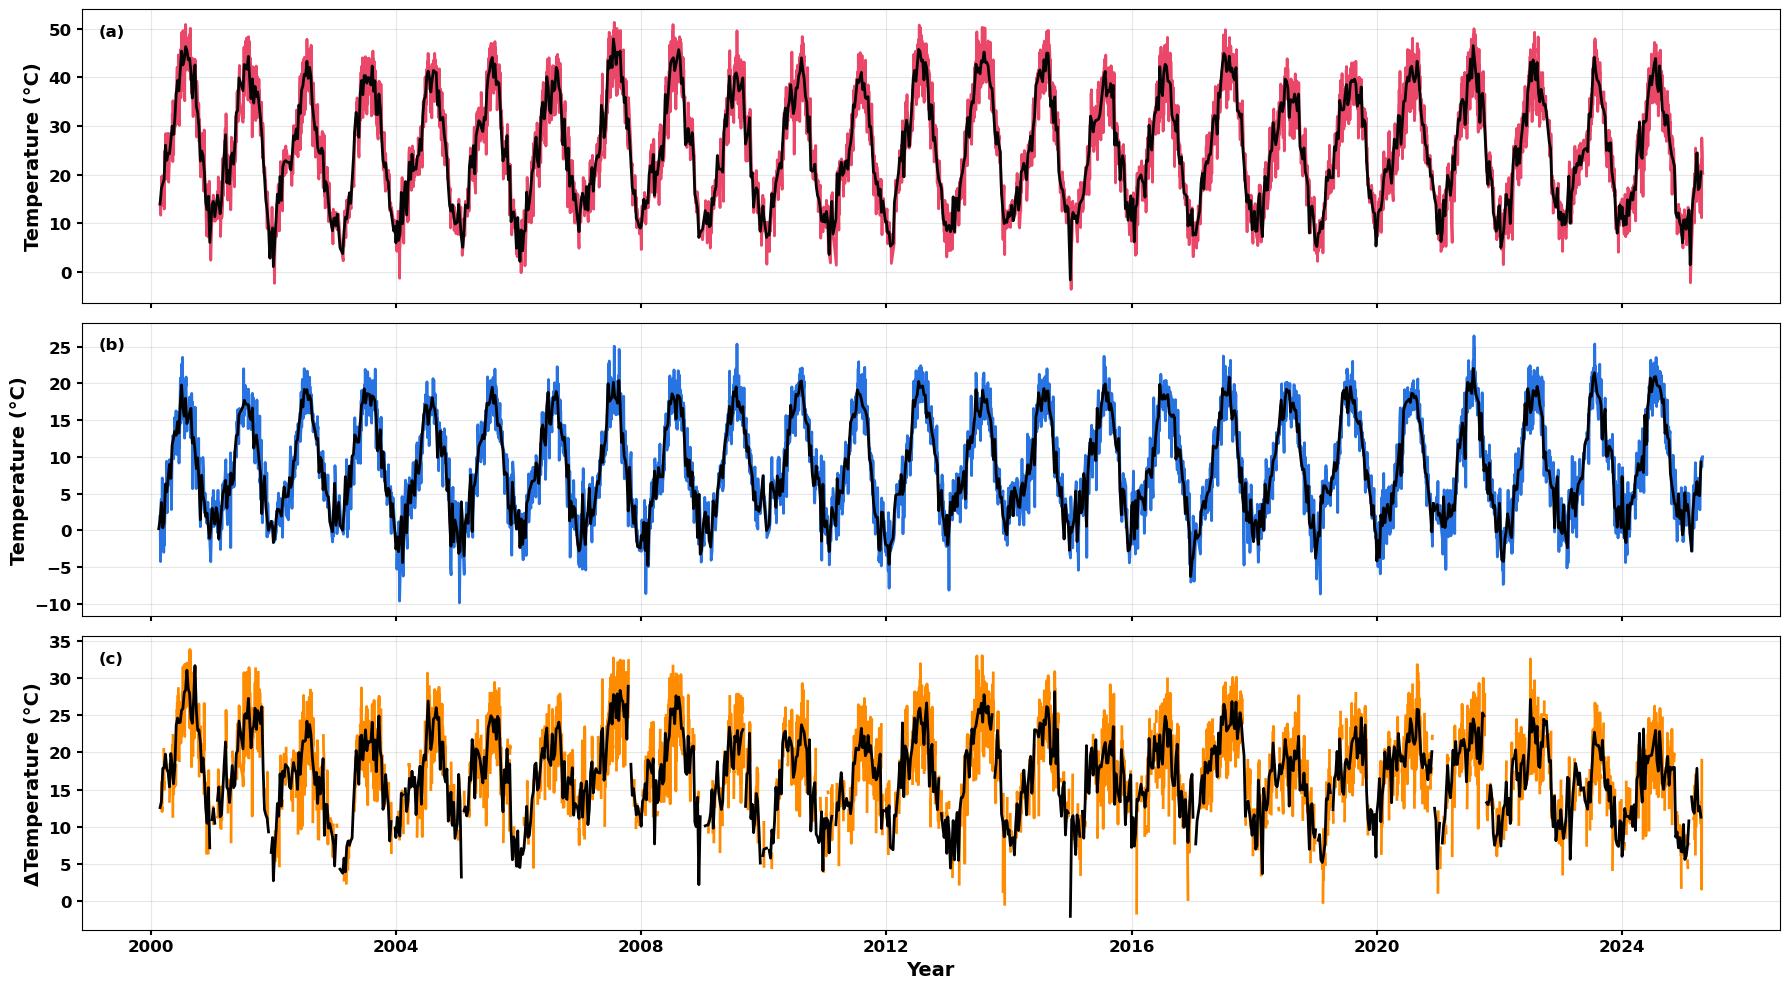

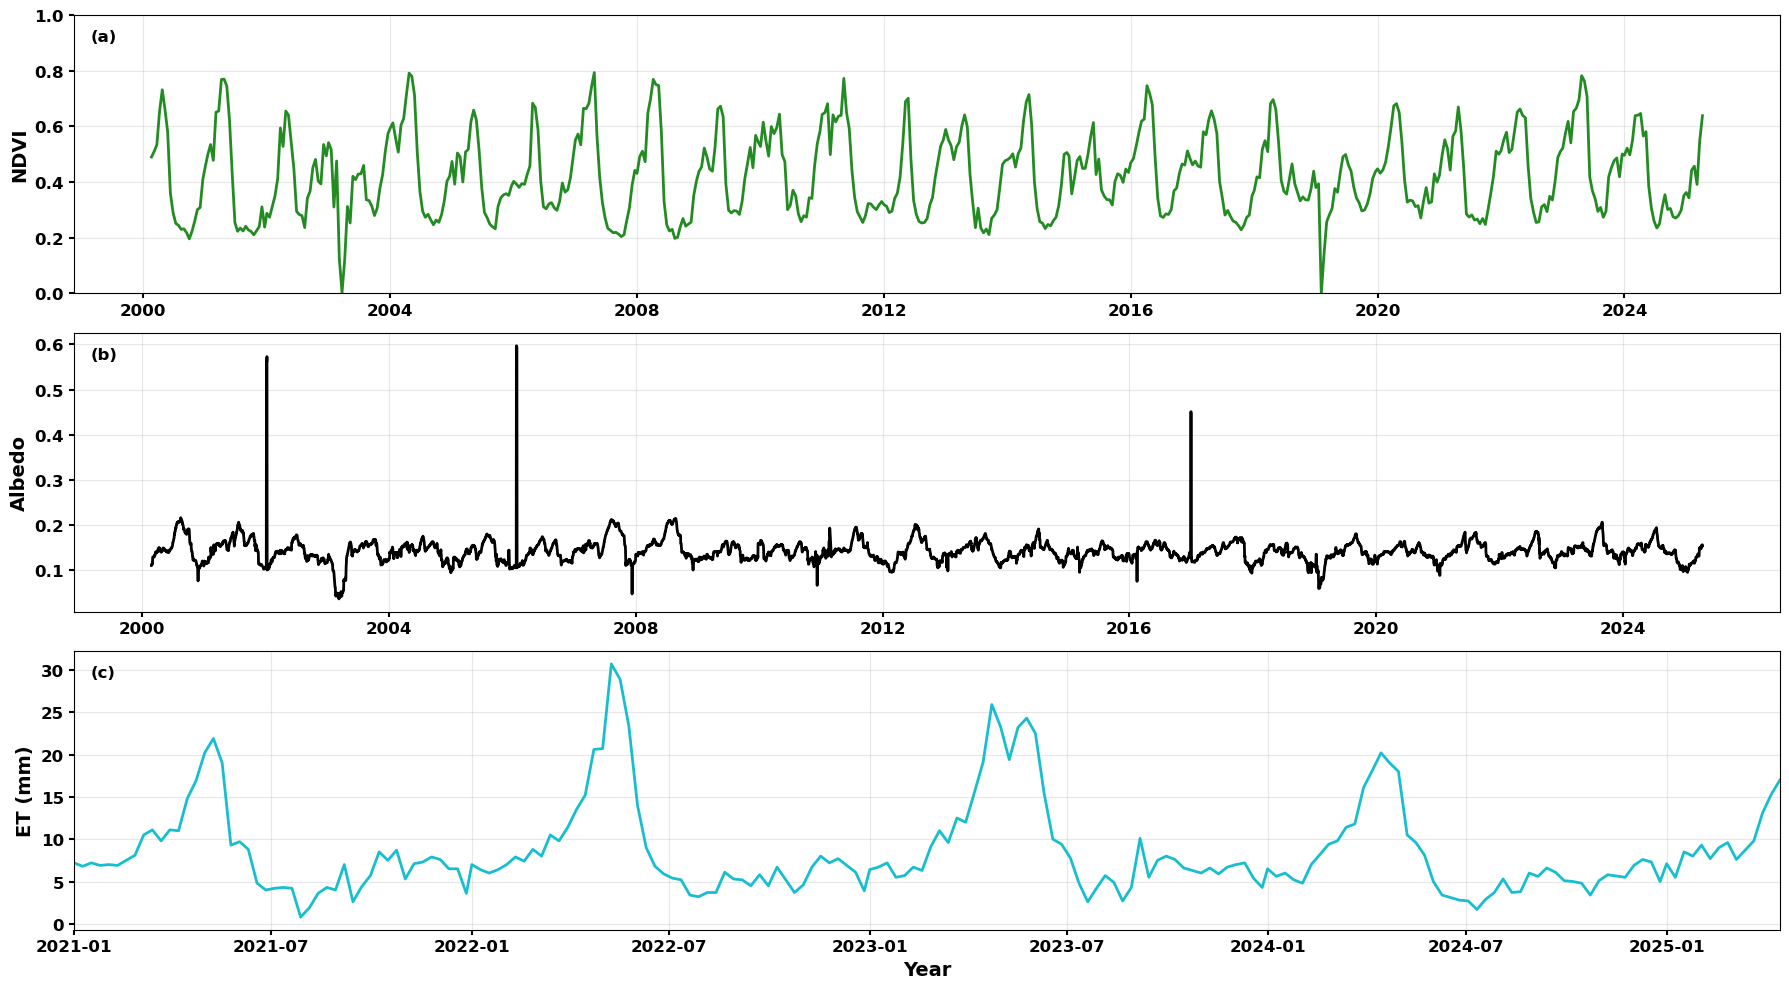

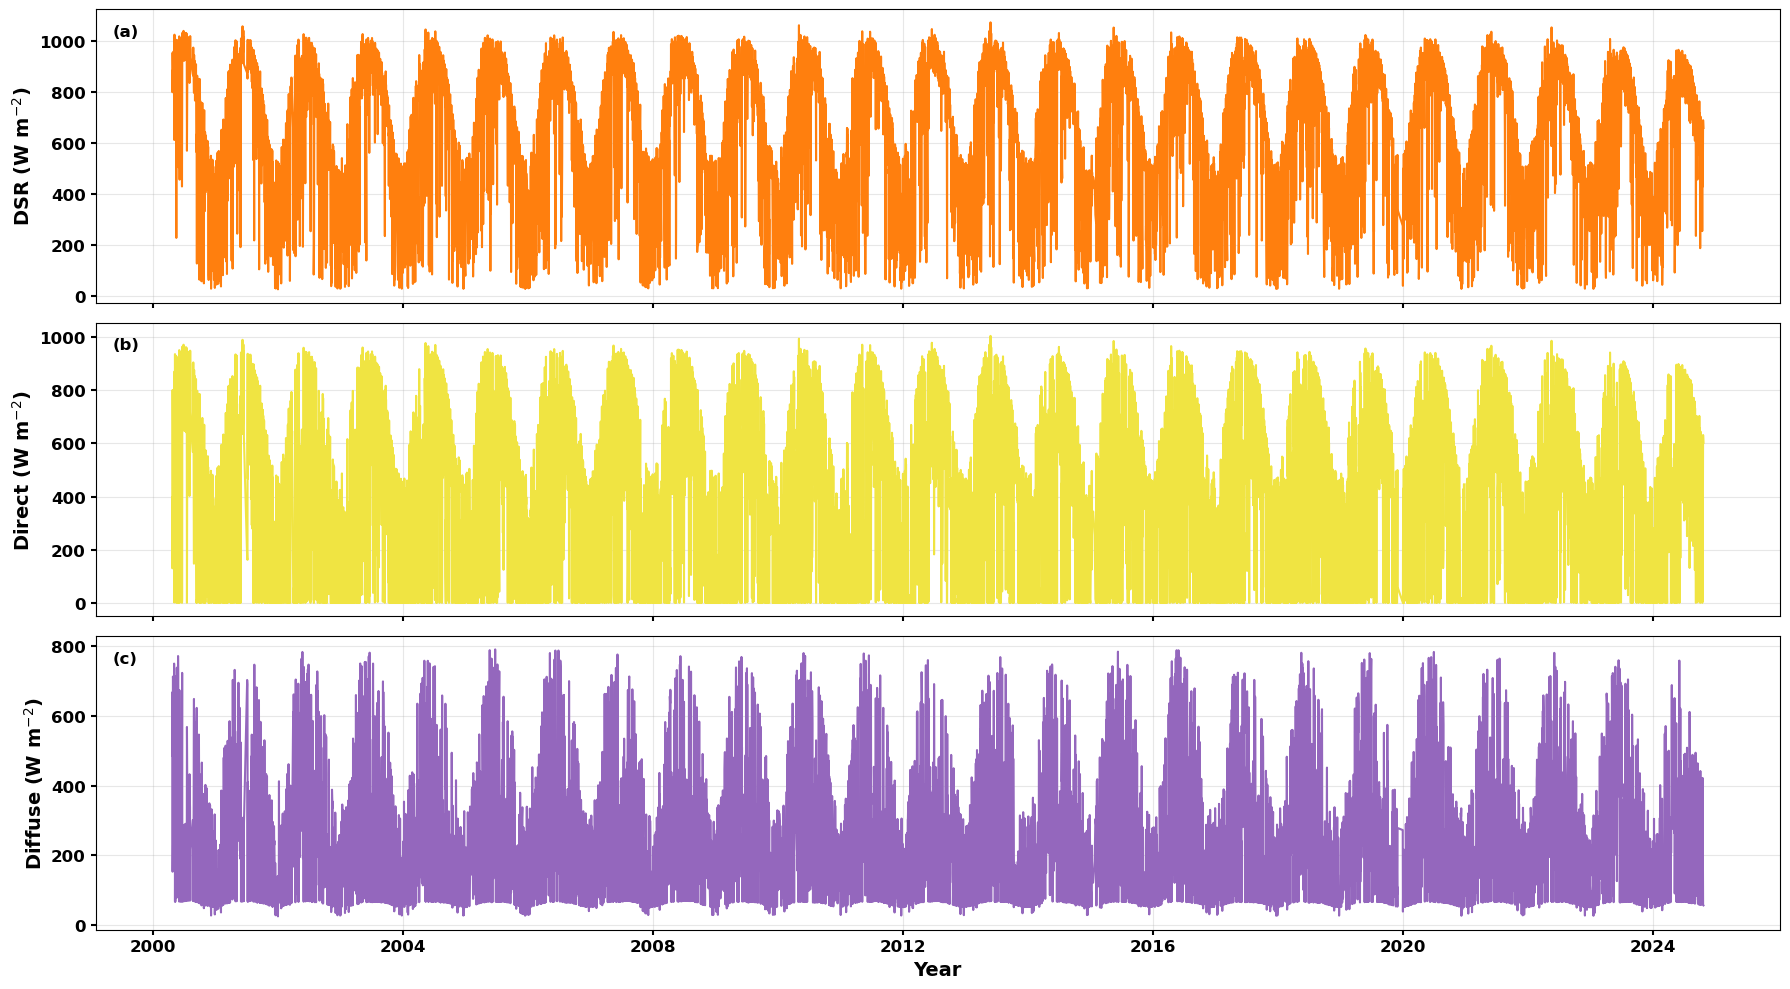

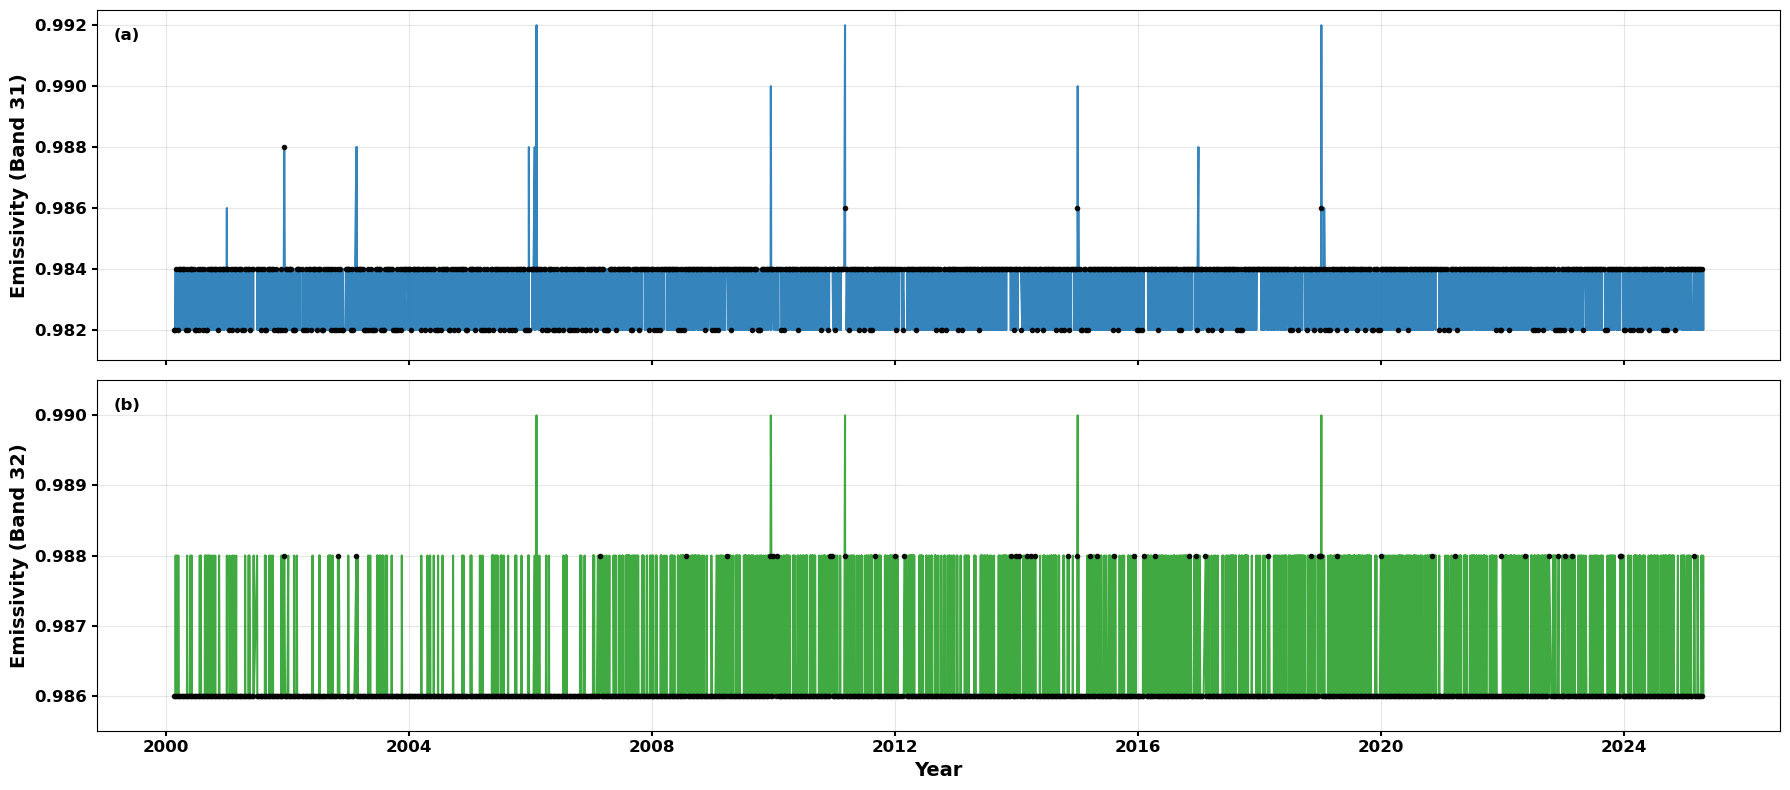

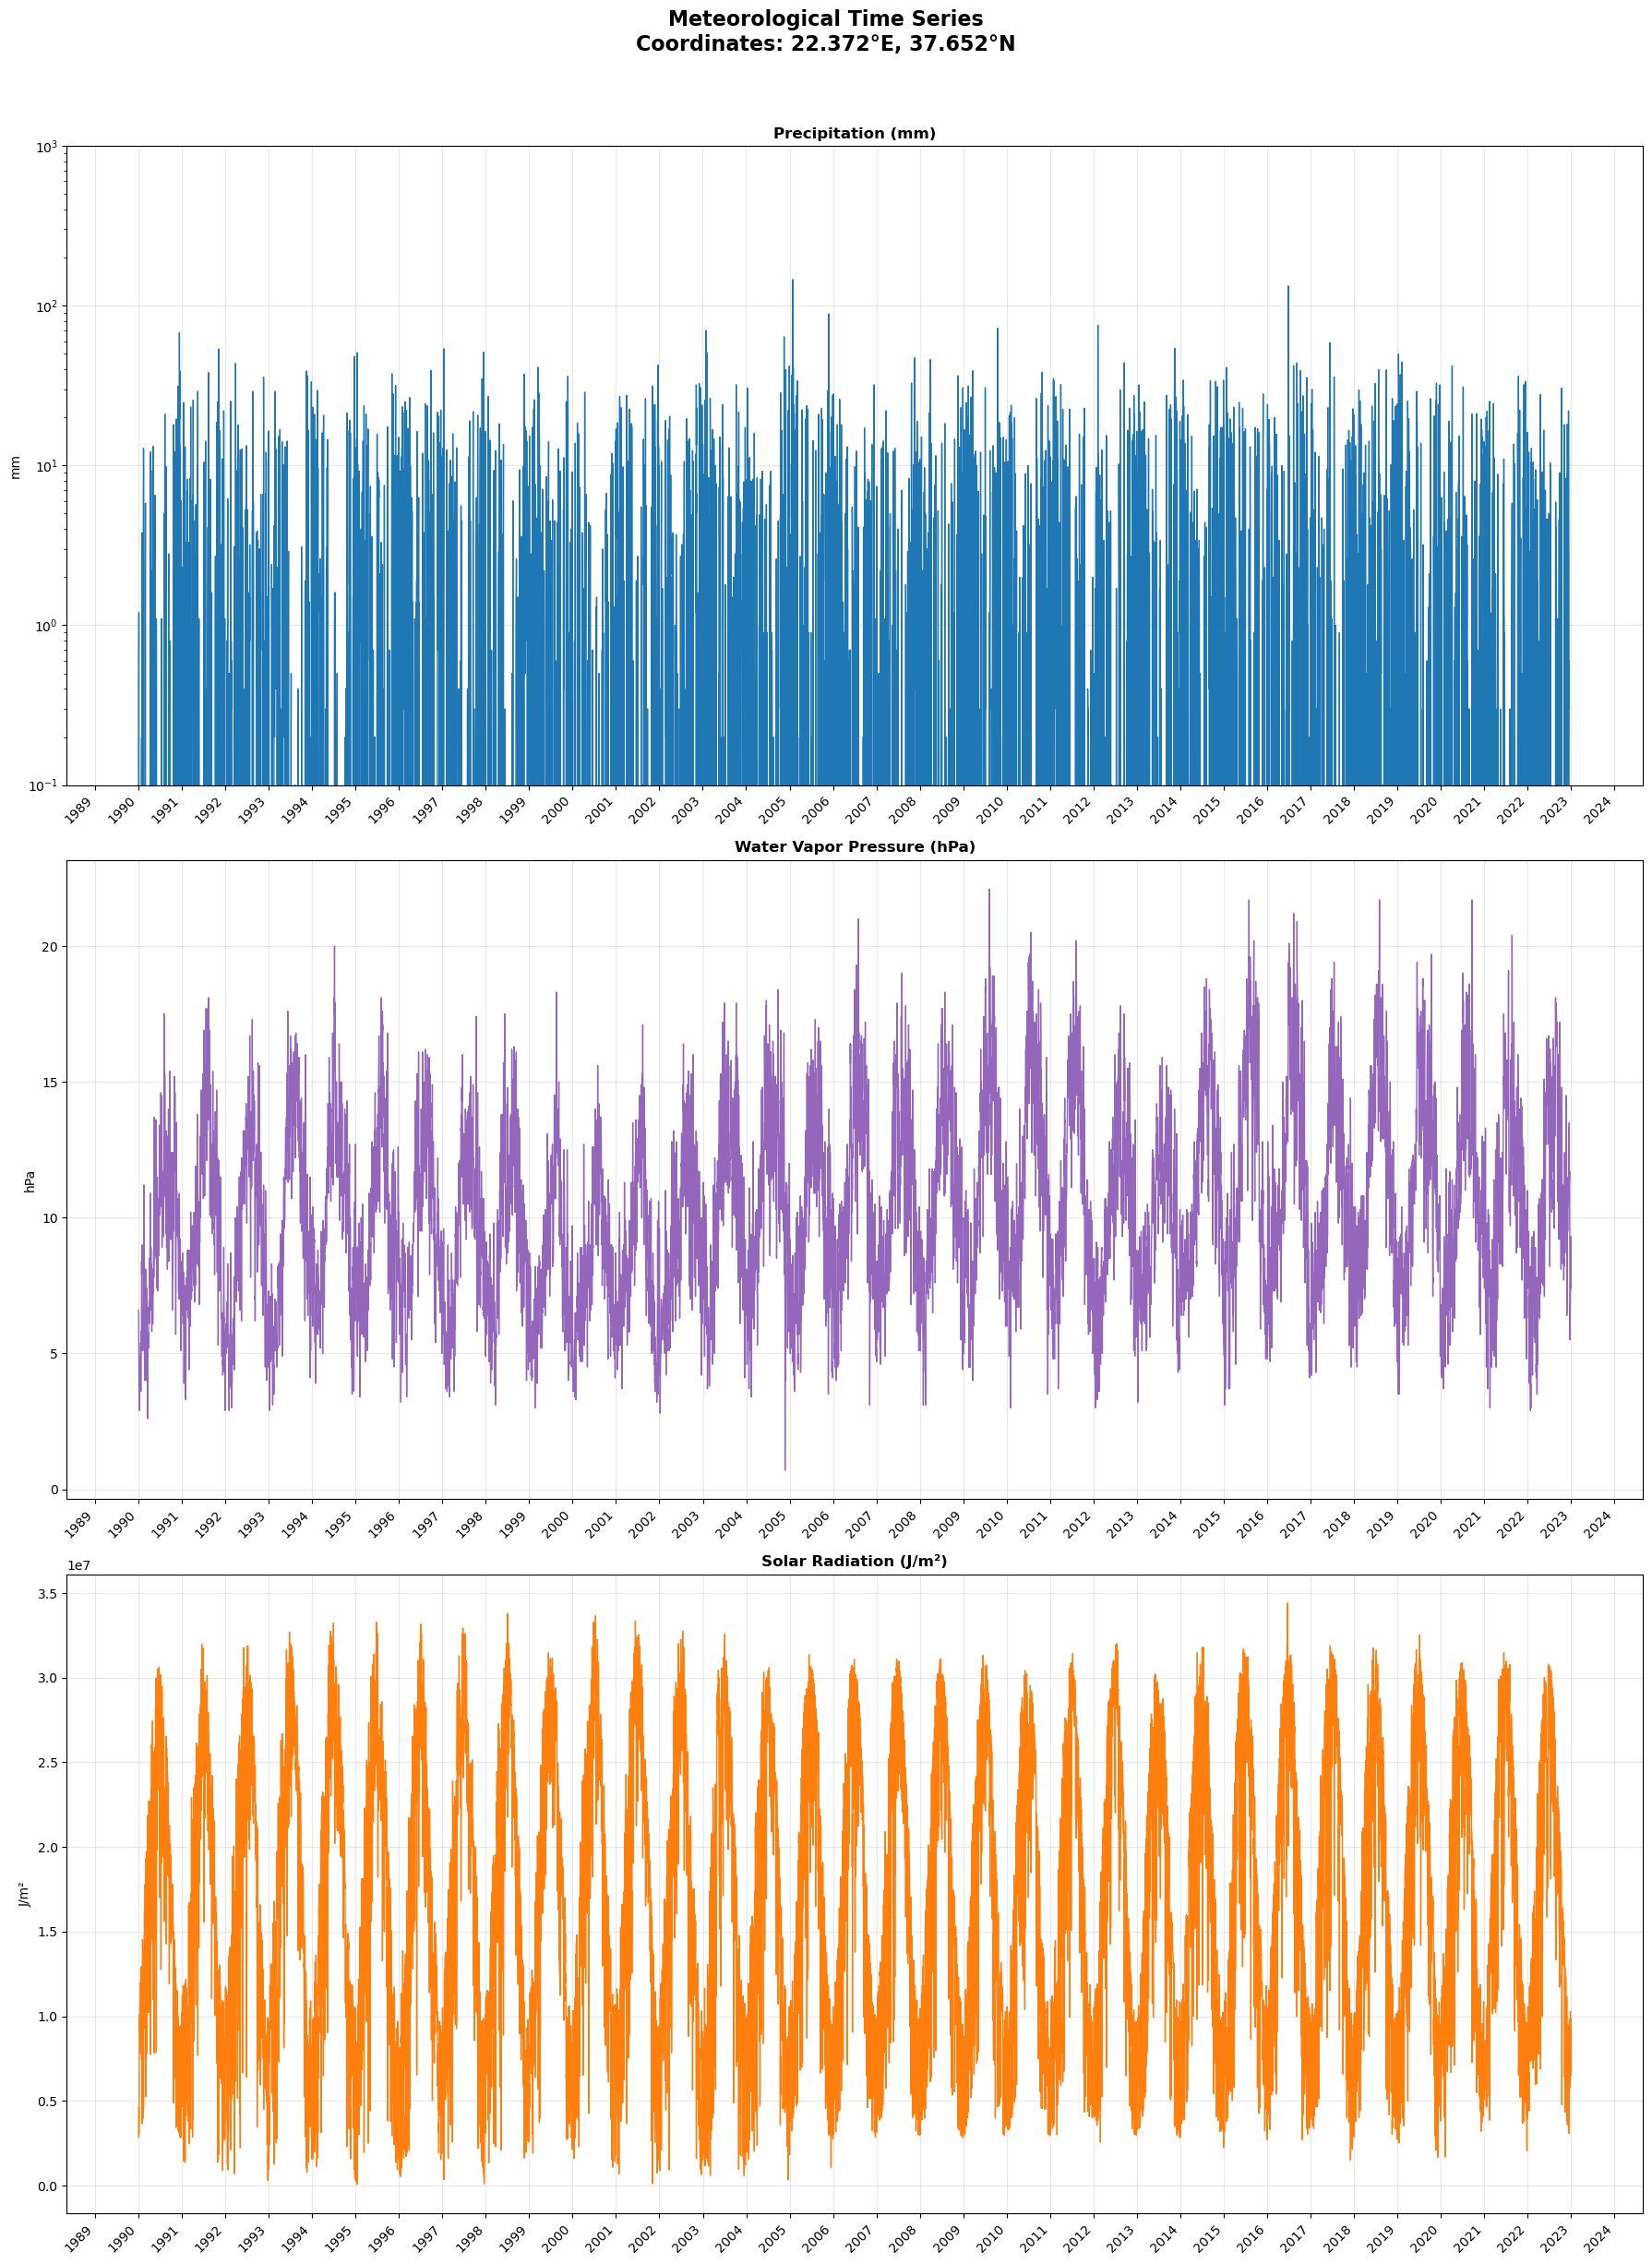

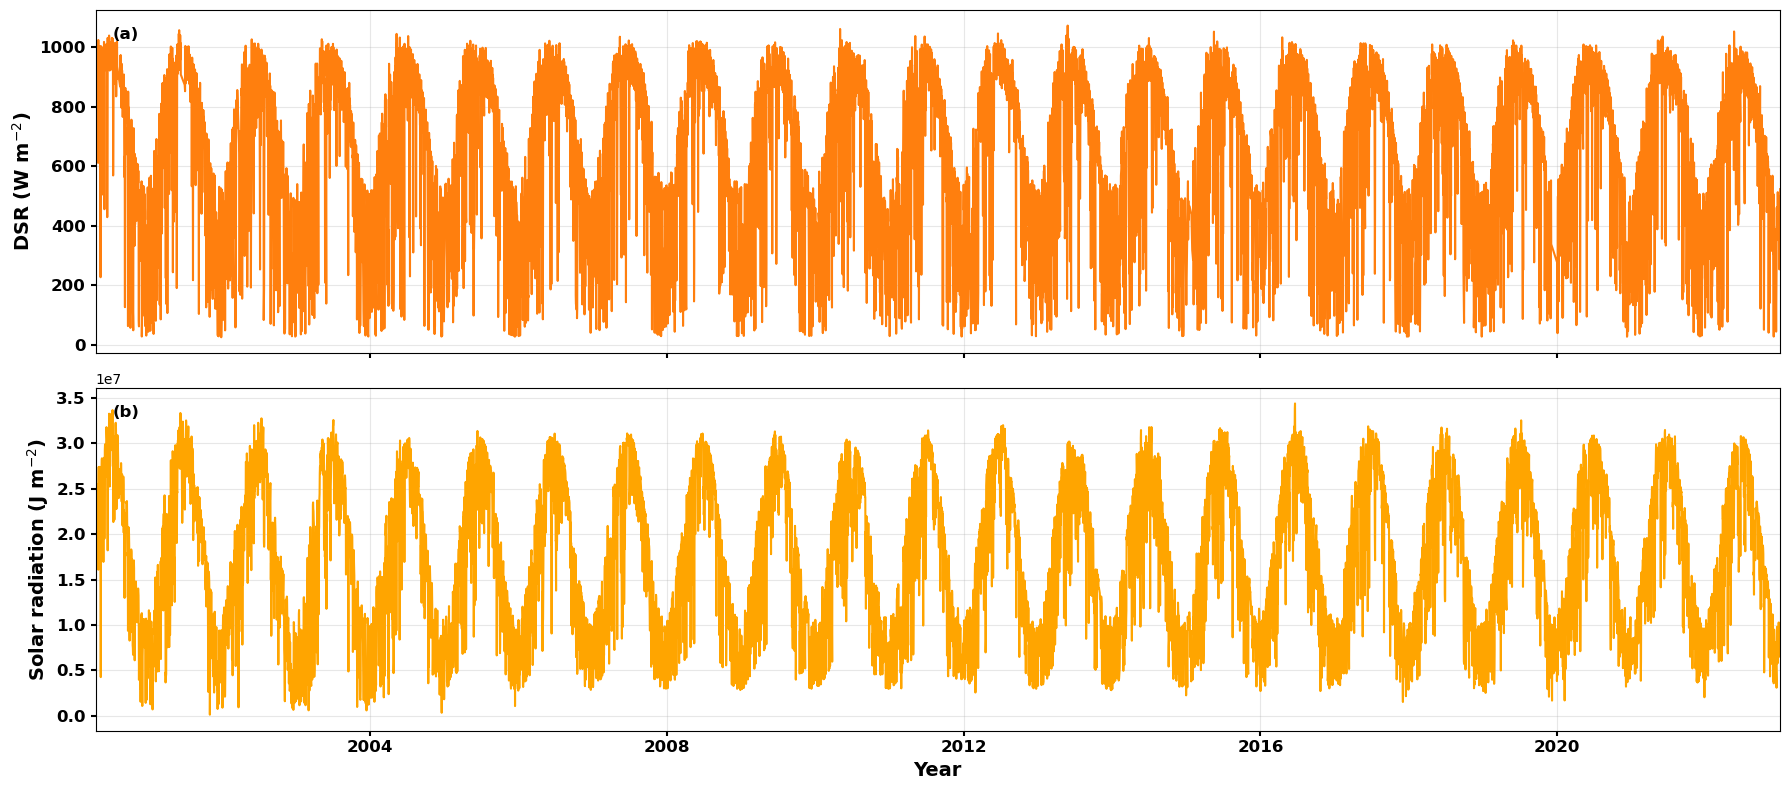

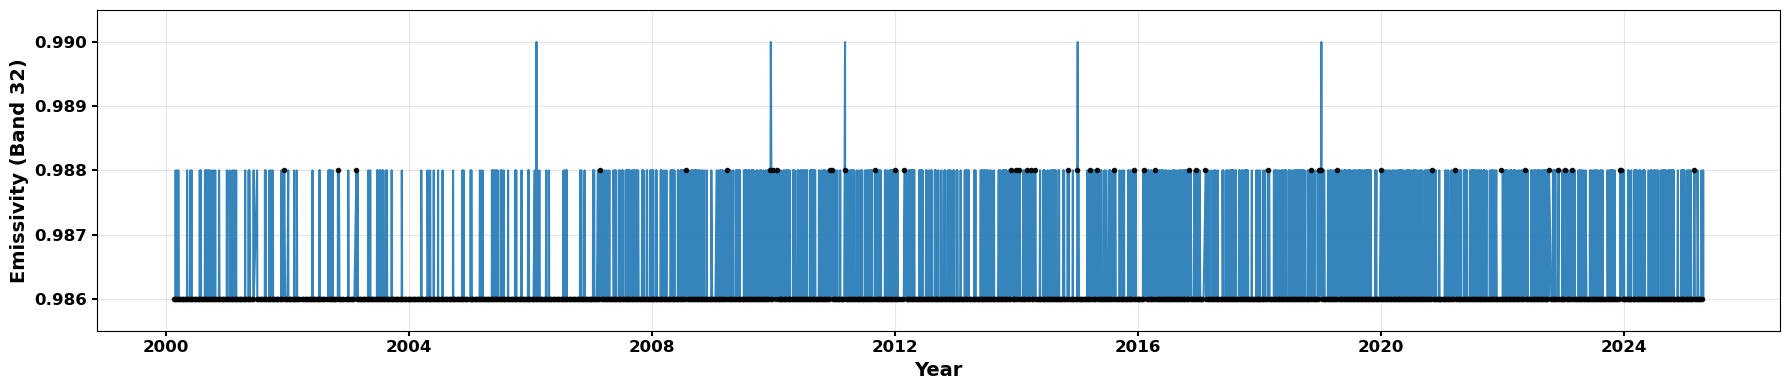


Analysis complete in 13.30 seconds


In [10]:
if __name__ == "__main__":
    print("Starting analysis...")
    start_time = time.time()
   

    # Option 1: Normal operation (uses cache if available)
    all_data, from_cache = load_or_process_data(force_reprocess=True)
    
    # Option 2: Force update cache files (recommended if we fresh/new data)
    #all_data = update_cache_files()
    
    # Generate and display correlation matrix with styling
    print("\nGenerating correlation matrix...")
    clean_corr_matrix = create_correlation_matrix(all_data)

    gmap = 1 - clean_corr_matrix.abs()  # So values near 0 get high color, ±1 get low
    styled_corr = clean_corr_matrix.style.background_gradient( cmap='coolwarm',  gmap=gmap,axis=None,vmin=-1, vmax=1)

    display(styled_corr)
    # display(clean_corr_matrix.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1))
    
    # Generate statistics
    print("\nGenerating statistics...")
    stats = generate_summary_statistics(all_data)
    display_summary_stats(stats)
    
    # Seasonal analysis
    print("\nCalculating seasonal statistics...")
    seasonal_stats = analyze_seasonal_data(all_data)
    display_seasonal_stats(seasonal_stats)
    
    # Generate plots
    print("\nGenerating plots...")
    plot_all_data(all_data)
    plot_radiation_combined(all_data['modis'], all_data['emo'])

    plot_emissivity_band32(all_data['modis'])

    print(f"\nAnalysis complete in {time.time()-start_time:.2f} seconds")